# Module 12 Lab - Distance Based Machine Learning

**kNN Regression**

We will use k-Nearest Neighbors regression for the insurance data set. We will:

1. Pick an appropriate evaluation metric.
2. Validation curves to find the best value of k.
3. Learning curves to see if we are high bias or high variance and suggest ways to improve the model.
4. 10 fold cross validation to estimate the mean metric and its credible interval.
5. Was this better than the best linear regression model we estimated in Lab 11? Use Bayesian statistical inference to generate and evaluate the posterior distribution of the difference of means.

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear
import models

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve


sns.set(style="whitegrid")

In [2]:
insurance = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/insurance.csv")
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


We see the data has loaded correctly.

Now we need to make dummy variables for Sex, Smoker and Region. We also want to add a column for bmi_above_30, as well as a squared age column. We also add our interaction terms for smoke_yes_bmi and smoke_yes_bmi_above_30.

In [3]:
insurance = pd.concat([insurance, pd.get_dummies(insurance["sex"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["region"])], axis=1)
insurance = pd.concat([insurance, pd.get_dummies(insurance["smoker"], prefix="smoke")], axis=1)
insurance["bmi_above_30"] = insurance.bmi.apply(lambda bmi: 1 if bmi > 30.0 else 0)
insurance["age_sq"] = insurance.age**2

insurance["smoke_yes_bmi"] = insurance["smoke_yes"] * insurance["bmi"]
insurance["smoke_yes_bmi_above_30"] = insurance["smoke_yes"] * insurance["bmi_above_30"]

insurance.head()

,age,sex,bmi,children,smoker,region,charges,female,male,northeast,northwest,southeast,southwest,smoke_no,smoke_yes,bmi_above_30,age_sq,smoke_yes_bmi,smoke_yes_bmi_above_30
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0,0,0,1,0,1,0,361,27.9,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0,0,1,0,1,0,1,324,0.0,0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0,0,1,0,1,0,1,784,0.0,0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0,1,0,0,1,0,0,1089,0.0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0,1,0,0,1,0,0,1024,0.0,0


We see that we have correctly created dummy variables for the categorical variables and added the bmi_above_30 column as well as the age_sq column and the interaction terms.

**1. Choose an appropriate evaluation metric.**

In order to evaluate our model, we must first choose an appropriate evaluation metric. The most popular choice is $R^2$, which measures the proportion of the data that is explained by our model. We choose $R^2$ to be our evaluation metric.

**2. Validation curves to find the best value of k.**

In order to choose the best value of $k$, we will try different ones and plot the results. For each potential value of $k$ (we try 1 through 9), we perform 10-fold cross validation and take the mean of the $R^2$ values for each $k$. We plot both the Training Score and the Cross Validation Score. What we are looking for is the maximum accuracy of the Cross Validation Score, which will give us the k we want to use.

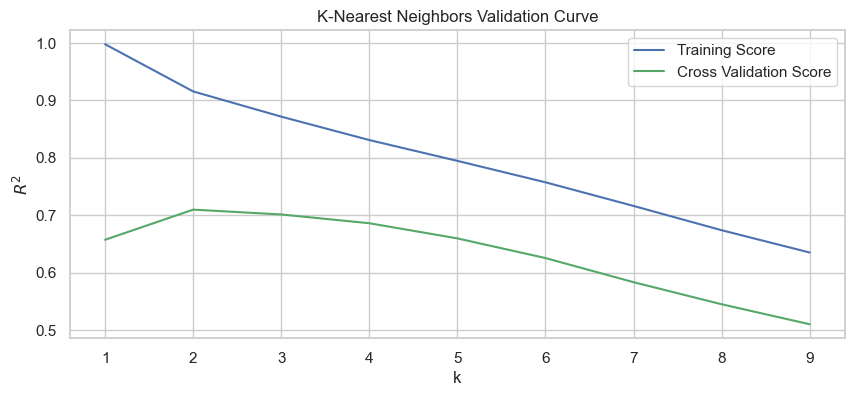

In [4]:
X = insurance[['age_sq', 'male', 'bmi', 'smoke_yes', 'smoke_yes_bmi', 'smoke_yes_bmi_above_30', 'children']]
y = insurance['charges']

parameter_range = np.arange(1, 10)

train_score, test_score = validation_curve(KNeighborsRegressor(), X, y, param_name="n_neighbors", param_range=parameter_range, cv=10, scoring="r2")

mean_train_score = np.mean(train_score, axis=1)
mean_test_score = np.mean(test_score, axis=1)

plt.figure(figsize=(10, 4))

plt.plot(parameter_range, mean_train_score, label="Training Score", color='b')
plt.plot(parameter_range, mean_test_score, label="Cross Validation Score", color='g')
plt.title("K-Nearest Neighbors Validation Curve")
plt.xlabel("k")
plt.ylabel("$R^2$")
plt.legend(loc='best')
plt.show()

Based on the chart, we can see that $k=2$ is our optimal parameter value. Choosing $k=2$ results in the largest $R^2$ value of around 0.71, which means that our model with $k=2$ explains the largest proportion of the data.

We verify this by printing the $R^2$ values for the given $k$ numbers.

In [5]:
for v, r in zip(parameter_range, mean_test_score):
    print("k =", v, ", ", "R^2 =", r)

k = 1 ,  R^2 = 0.6571834693115239
k = 2 ,  R^2 = 0.7096287257563456
k = 3 ,  R^2 = 0.7012090999580062
k = 4 ,  R^2 = 0.685937903835139
k = 5 ,  R^2 = 0.659523270156786
k = 6 ,  R^2 = 0.6253193826136214
k = 7 ,  R^2 = 0.5832829813433991
k = 8 ,  R^2 = 0.5448582576632699
k = 9 ,  R^2 = 0.510035811348866


We confirm that for $k=2$, we get our largest $R^2$ of 0.7096. Thus, we choose $k=2$.

**3. Learning curves to see if we are high bias or high variance, and ways to improve the model.**

Now we want to determine whether or not more data will improve our model or not. In order to find out, we train/test our model on increasing amounts of our data, starting with a small amount and finishing with the whole dataset. We then plot the $R^2$ for each iteration. What we want to see is the $R^2$ plateau. If instead the $R^2$ appears to still be increasing after using our whole dataset, then we have a good idea that collecting more data would improve our $R^2$. If instead the $R^2$ plateaus by the time we use all the data, then we can be decently sure that adding more data would not help our model, and we can instead focus on other ways to improve it.

We plot the learning curves below.

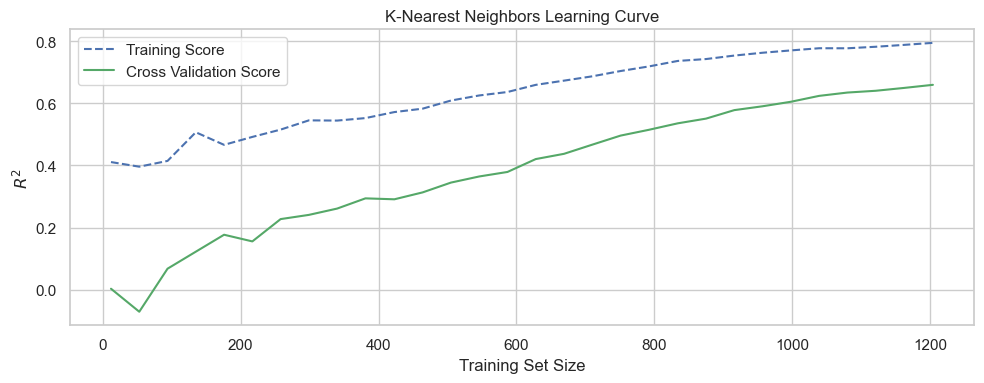

In [6]:
sizes, training_scores, testing_scores = learning_curve(KNeighborsRegressor(), X, y, cv=10, scoring='r2', train_sizes=np.linspace(0.01, 1.0, 30))

mean_training = np.mean(training_scores, axis=1)
mean_testing = np.mean(testing_scores, axis=1)

plt.figure(figsize=(10, 4))

plt.plot(sizes, mean_training, '--', color="b",  label="Training Score")
plt.plot(sizes, mean_testing, color="g", label="Cross Validation Score")

plt.title("K-Nearest Neighbors Learning Curve") 
plt.xlabel("Training Set Size"), plt.ylabel("$R^2$"), plt.legend(loc="best") 
plt.tight_layout() 
plt.show()

Interestingly, we notice that the $R^2$ value seems to be in the process of increasing when we run out of data. As we noted before, this trend indicates that our model was still getting better as we were adding more data, right up until the end of the data we have. Thus, we can comfortably say that it is likely our model would benefit from having more data to train on. As we noted during our EDA, our data only has 1337 datapoints, which is relatively low. Gathering more data would likely improve our model.

**4. Three rounds of 10-fold cross validation to estimate the mean metric and its credible interval.**

Now we want to obtain the $R^2$ value (our chosen evaluation metric) of the model. To get an accurate $R^2$, we perform three rounds of 10-fold cross validation. 

To do this, we divide our data into 10 "folds", then iterate through the folds, choosing 1 fold as the test set and the remaining 9 folds as the training set. For each iteration, we calculate the $R^2$ of the resulting model, testing using the test fold. We then take the average of these 10 iterations, and print it. We repeat this entire process three times in a loop, printing the average $R^2$ value each time.

We use $k=2$ for our model since we determined above that 2 was our optimal $k$ value.

In [7]:
model = KNeighborsRegressor(n_neighbors=2)
folds = 10
r2_scores_total_knn = []

for x in range(0, 3):
    kf = KFold(n_splits=folds, shuffle=True, random_state=x)  # Use a different random_state for each round
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
    r2_scores_total_knn.extend(r2_scores)
    print("R^2: ", r2_scores.mean())

R^2:  0.7021614600832564
R^2:  0.7033906163991785
R^2:  0.7001743798897171


We see that our $R^2$ values are all pretty close to one another, and they are all close to the 0.709 that we observed earlier. 

In [8]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

**5. Was this better than the best linear regression model we estimated in Lab 11?**

In order to answer this question, we will use Bayesian statistical inference to generate and evaluate the posterior distribution of the difference of means between the $R^2$ of our new K-nearest neighbors model, and our old linear regression model.

We start by generating our $R^2$ scores for the linear regression model we created in the previous lab. To generate the scores, we once again perform three rounds of 10-fold cross validation. We print the average $R^2$ scores for each round of 10-fold cross validation and compare with the previous assignment to confirm.

In [9]:
model = LinearRegression()
folds = 10
r2_scores_total_linear_regression = []
rmse_scores_total = []

for x in range(0, 3):
    kf = KFold(n_splits=folds, shuffle=True, random_state=x)  # Use a different random_state for each round
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
    r2_scores_total_linear_regression.extend(r2_scores)
    print("R^2: ", r2_scores.mean())

R^2:  0.8638952717004669
R^2:  0.8671669401413457
R^2:  0.8613113586719026


We see that our $R^2$ values are around 0.86, which is consistent with the results of our previous model.

Now let's plot the $R^2$ values for each model. We expect the charts to align with our findings. We expect the KNN model's $R^2$ values to be centered around 0.70, and we expect the Linear Regression model's $R^2$ values to be centered around 0.86.

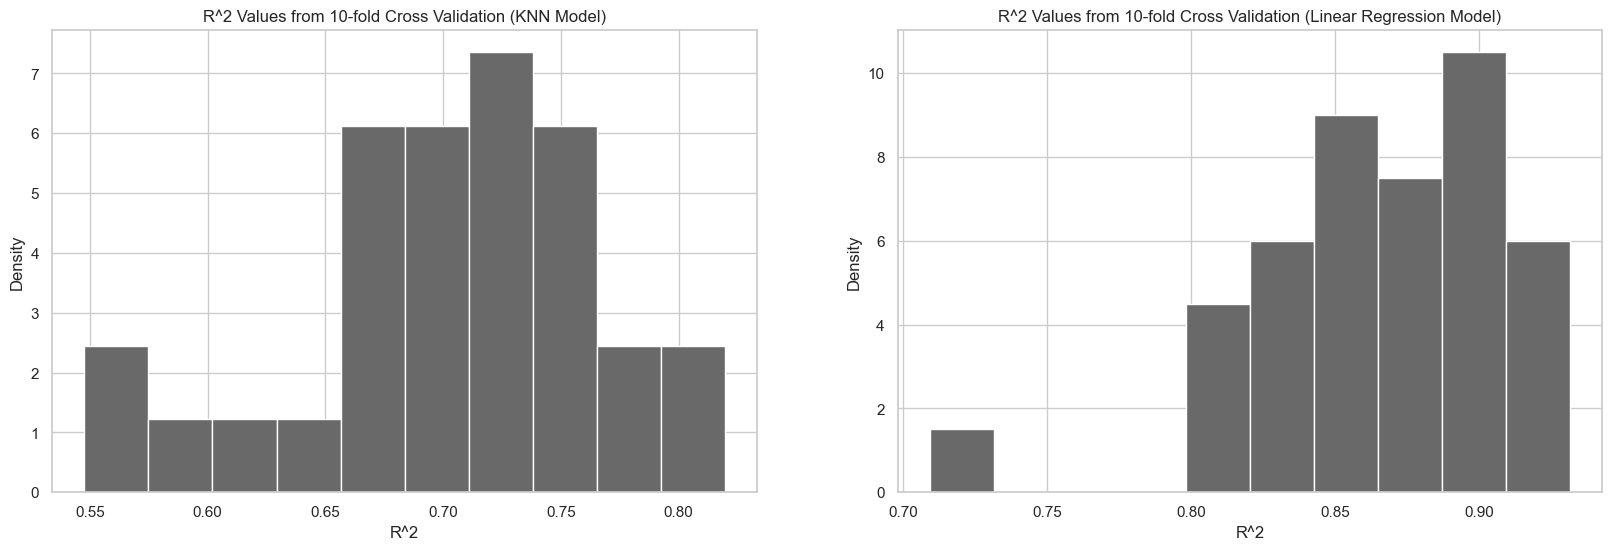

In [10]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 2, 1)

axes.hist(r2_scores_total_knn, density=True, color="dimgray")
axes.set_ylabel( "Density")
axes.set_xlabel( "R^2")
axes.set_title( "R^2 Values from 10-fold Cross Validation (KNN Model)")

axes = figure.add_subplot(1, 2, 2)

axes.hist(r2_scores_total_linear_regression, density=True, color="dimgray")
axes.set_ylabel( "Density")
axes.set_xlabel( "R^2")
axes.set_title( "R^2 Values from 10-fold Cross Validation (Linear Regression Model)")

plt.show()
plt.close()

As we expected, the KNN model's $R^2$ values are centered around 0.70, and the Linear Regression model's $R^2$ values are centered around 0.86. No surprise here.

Now we take bootstrap samples of these two lists. We then plot the bootstrap samples, as well as their differences. We expect to see both models centered around the same $R^2$ values, but for the distributions to appear smoother, since we will have taken many bootstrap samples.

In [11]:
posterior_knn = bootstrap_sample(r2_scores_total_knn, np.mean, 1000)
posterior_linear_regression = bootstrap_sample(r2_scores_total_linear_regression, np.mean, 1000)
difference = posterior_linear_regression - posterior_knn

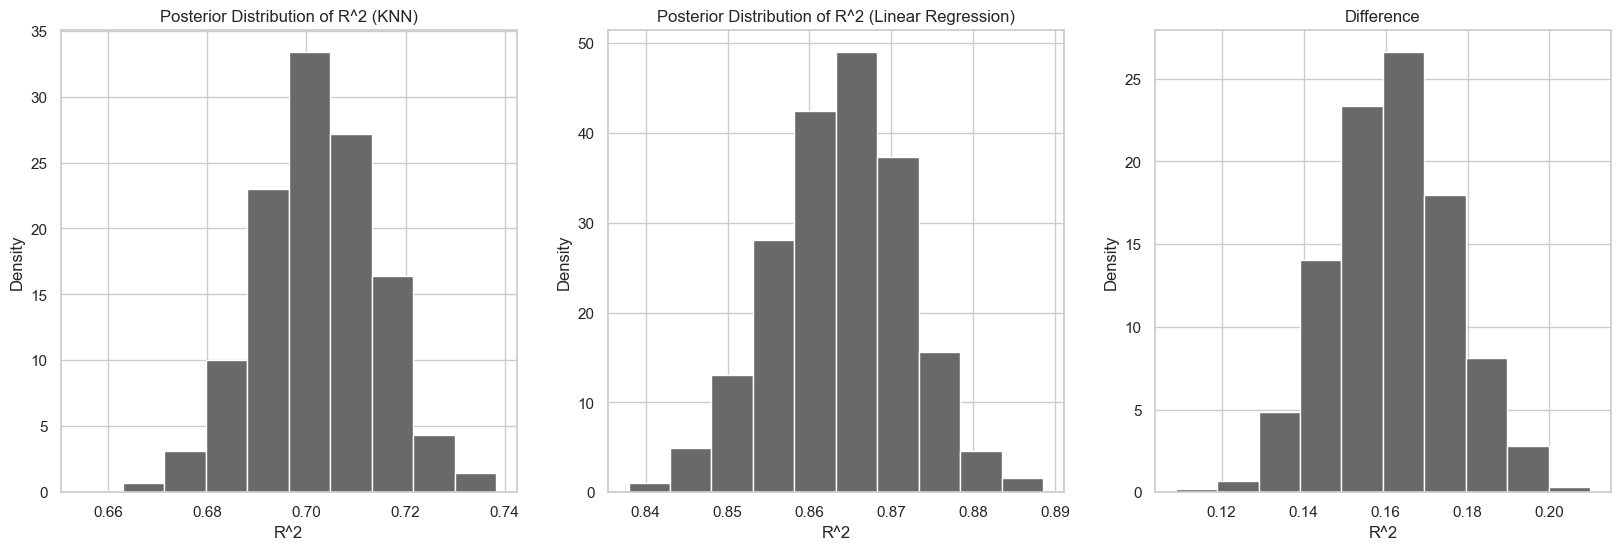

In [12]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(posterior_knn, density=True, color="dimgray")
axes.set_ylabel( "Density")
axes.set_xlabel( "R^2")
axes.set_title( "Posterior Distribution of R^2 (KNN)")

axes = figure.add_subplot(1, 3, 2)

axes.hist(posterior_linear_regression, density=True, color="dimgray")
axes.set_ylabel( "Density")
axes.set_xlabel( "R^2")
axes.set_title( "Posterior Distribution of R^2 (Linear Regression)")

axes = figure.add_subplot(1, 3, 3)

axes.hist(difference, density=True, color="dimgray")
axes.set_ylabel( "Density")
axes.set_xlabel( "R^2")
axes.set_title( "Difference")


plt.show()
plt.close()

As we expected, the distributions are each centered around their respective mean $R^2$ values, and the distributions are smoother with the high number of bootstrap samples.

We also observe that the differences are centered around 0.16 or so, indicating an approximate average difference of 0.16 between the KNN model's $R^2$ values and the Linear Regression model's $R^2$ values.

Now we calculate the 95% confidence intervals for each model as well as the difference.

In [13]:
print( "95% BCI for R^2 of KNN Model:", stats.mstats.mquantiles(posterior_knn, [0.025, 0.975]))
print( "95% BCI for R^2 of Linear Regression Model:", stats.mstats.mquantiles(posterior_linear_regression, [0.025, 0.975]))
print( "95% BCI for Difference:", stats.mstats.mquantiles(difference, [0.025, 0.975]))

95% BCI for R^2 of KNN Model: [0.67701415 0.72478528]
95% BCI for R^2 of Linear Regression Model: [0.84739602 0.87906064]
95% BCI for Difference: [0.1339867  0.19216155]


We find that 95% of the posterior distribution for $R^2$ of the KNN model is within the range 0.678 and 0.726, and that 95% of the posterior distribution for $R^2$ of the Linear Regression model is within the range 0.847 and 0.880. We also find that 95% of the difference is between 0.134 and 0.189.

Now we want to determine what difference between the models' $R^2$ values is and is not important.

Thinking about our different models and the tweaking it took to increase the performance of the linear regression model, we decide that a difference of 5 percentage points of $R^2$ is significant. Thus, we define our ROPE to be 0.05 for the difference in $R^2$. The question we want to answer is, "what is the probability that the $R^2$ of the linear regression model is larger than the $R^2$ of the KNN model by at least 0.05?".

In [14]:
np.mean((0.05 <= difference))

1.0

Unsurprisingly, we find that there is a 100% chance that the $R^2$ of the linear regression model is larger than the $R^2$ of the KNN model by at least 0.05. In other words, there is a 100% chance that the linear regression model is better than the KNN model.